In [1]:
# Change directory so that code in "src" directory is easily importable.
import os
os.chdir('../')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import requests

from pyathena import connect
from pyathena.pandas_cursor import PandasCursor

#from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVR, LinearSVC
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, roc_auc_score, accuracy_score, balanced_accuracy_score
from sklearn.metrics import make_scorer, SCORERS, f1_score, precision_score, recall_score

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import tensorflow as tf
from tensorflow import keras

import time

import warnings

#warnings.simplefilter(action='ignore', category=FutureWarning)

pd.options.mode.chained_assignment = None  # default='warn'
#pd.options.display.max_columns = 30
#pd.options.display.max_rows = 50

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 100)

# Define connection to DB
conn = connect(
    s3_staging_dir='s3://aws-athena-query-results-323906537337-us-east-1/',
    region_name='us-east-1',
    cursor_class=PandasCursor
    )
cursor = conn.cursor()

In [ ]:
tf.__version__

# 0 Data

## 0.1 pbp data

In [3]:
# playtypeid:
# 1 = pass attempt
# 2 = incomplete pass attempt
# 3 = sack
# 4 = designed rush OR scramble
# 9 = intercepted pass attempt

simple_query = f'''
select
    cast(season as integer) season,
    eventmetadata.week, eventmetadata.gamecode, eventmetadata.eventtypeid, eventmetadata.gamedateutcepoch gameUTCTime,
    if(teammetadata[1].ishometeam, teammetadata[1].teamid, teammetadata[2].teamid) homeTeam,
    if(teammetadata[2].ishometeam, teammetadata[1].teamid, teammetadata[2].teamid) awayTeam,
        
    pbp.startpossessionteamid offenseTeam, 
    -- pbp.endpossessionteamid,
    if(pbp.startpossessionteamid = teammetadata[1].teamid, teammetadata[2].teamid, teammetadata[1].teamid) defenseTeam,
    
    cast(playid as integer) playid, pbp.driveid, pbp.period,  
    cast(secondsremaininginperiod as double) secondsRemainingInPeriod,
    
    cast((pbp.period - 1) * 900 + (900 - secondsRemainingInPeriod) as double) gameTime,
    secondsRemainingInPeriod + GREATEST(4 - pbp.period, 0) * 900 remainingGameTime,
    
    case 
        when pbp.period in (1,2) then 1
        when pbp.period in (3,4) then 2
        else 3
        end halfGame,
    
    case 
        when pbp.down is null then 0
        else pbp.down
        end down,
        
    case
        when pbp.distance is null then 0.0
        else cast(pbp.distance as double) 
        end yardsToGo,
        
    cast(pbp.startyardsfromgoal as double) yardsFromGoal, 

    pbp.awayscorebefore awayScore, 
    pbp.homescorebefore homeScore,
    pbp.awayscoreafter  awayScoreAfter, 
    pbp.homescoreafter  homeScoreAfter,
    if(teammetadata[1].ishometeam, teammetadata[1].score, teammetadata[2].score) homeFinalScore,
    if(teammetadata[2].ishometeam, teammetadata[1].score, teammetadata[2].score) awayFinalScore,
    
    case
    when teammetadata[1].teamid = pbp.startpossessionteamid and teammetadata[1].ishometeam then pbp.homescorebefore
    when teammetadata[2].teamid = pbp.startpossessionteamid and teammetadata[2].ishometeam then pbp.homescorebefore
    else pbp.awayscorebefore
    end as offenseScore,
    
    pbp.playtype.playtypeid, pbp.playtype.name playName,
    
    --ceate known playtype pre-play
    case
        when pbp.playtype.playtypeid in (22) then 1
        when pbp.playtype.playtypeid in (52, 53, 54, 55, 56) then 2
        when pbp.playtype.playtypeid in (42, 35, 36) then 3
        else 0
        end playDesign,
    
    case 
        when pbp.playtype.playtypeid = 57 then 1
        else 0
        end offenseTimeout,
        
    case 
        when pbp.playtype.playtypeid = 58 then 1
        else 0
        end defenseTimeout
        
from 
    datalakefootball.pbp_xinfo_enriched
where 
    season>='2016' and season<='2019'
    and eventmetadata.eventtypeid in (1,2)
    -- pbp.period <= 4
    -- and pbp.down is not null -- this will elliminate field goal attempts and a few other actions
    and pbp.playtype.playtypeid not in (5,13) -- 2-min warning, kickoff
order by season, eventmetadata.week, eventmetadata.gamecode, pbp.period, playid, secondsremaininginperiod desc
'''

if True:
    pbp_df = cursor.execute(simple_query).as_pandas()
    print(pbp_df.info())
else:
    print("Failed to query!")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173665 entries, 0 to 173664
Data columns (total 31 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   season                    173665 non-null  Int64  
 1   week                      173665 non-null  Int64  
 2   gamecode                  173665 non-null  Int64  
 3   eventtypeid               173665 non-null  Int64  
 4   gameUTCTime               173665 non-null  Int64  
 5   homeTeam                  173665 non-null  Int64  
 6   awayTeam                  173665 non-null  Int64  
 7   offenseTeam               173665 non-null  Int64  
 8   defenseTeam               173665 non-null  Int64  
 9   playid                    173665 non-null  Int64  
 10  driveid                   173665 non-null  Int64  
 11  period                    173665 non-null  Int64  
 12  secondsRemainingInPeriod  173665 non-null  float64
 13  gameTime                  173665 non-null  f

In [4]:
# fix a DB error
id = (pbp_df.gamecode==1744923) & (pbp_df.driveid.isin([22]))
pbp_df.loc[id, 'offenseTeam'] = 354
pbp_df.loc[id, 'defenseTeam'] = 339

In [5]:
pbp_df['scoreDiff'] = pbp_df.homeScore - pbp_df.awayScore
pbp_df.loc[pbp_df.offenseTeam==pbp_df.awayTeam, 'scoreDiff'] = pbp_df.awayScore - pbp_df.homeScore
pbp_df.scoreDiff = pbp_df.scoreDiff.astype('float64') #important for num features

pbp_df['scoreDiffAfter'] = pbp_df.homeScoreAfter - pbp_df.awayScoreAfter
pbp_df.loc[pbp_df.offenseTeam==pbp_df.awayTeam, 'scoreDiffAfter'] = pbp_df.awayScoreAfter - pbp_df.homeScoreAfter
pbp_df.scoreDiffAfter = pbp_df.scoreDiffAfter.astype('float64') #important for num features

In [6]:
#pbp_df['adjScoreDiff'] = pbp_df.scoreDiff / np.sqrt(pbp_df.remainingGameTime+1)
pbp_df['adjScoreDiff'] = pbp_df.scoreDiff / np.power(pbp_df.remainingGameTime+1, 0.5)

In [7]:
# calculate remaining TO
# > calculate timeout used in each half game

pbp_df[['homeTO','awayTO','remainingHomeTOs','remainingAwayTOs']] = 0

id = ((pbp_df.offenseTimeout == 1) & (pbp_df.offenseTeam == pbp_df.homeTeam)) | \
        ((pbp_df.defenseTimeout == 1) & (pbp_df.defenseTeam == pbp_df.homeTeam))
pbp_df.loc[id, 'homeTO'] = 1

id = ((pbp_df.offenseTimeout == 1) & (pbp_df.offenseTeam == pbp_df.awayTeam)) | \
        ((pbp_df.defenseTimeout == 1) & (pbp_df.defenseTeam == pbp_df.awayTeam))
pbp_df.loc[id, 'awayTO'] = 1

gd = pbp_df.groupby(['gamecode','halfGame'])
pbp_df[['remainingHomeTOs','remainingAwayTOs']] = 3 - gd[['homeTO','awayTO']].cumsum()

pbp_df[['remainingOffenseTOs','remainingDefenseTOs']] = pbp_df[['remainingHomeTOs','remainingAwayTOs']].copy()

id = (pbp_df.offenseTeam == pbp_df.awayTeam)

pbp_df.loc[id, 'remainingOffenseTOs'] = pbp_df.loc[id, 'remainingAwayTOs'].values.astype('float64')
pbp_df.loc[id, 'remainingDefenseTOs'] = pbp_df.loc[id, 'remainingHomeTOs'].values.astype('float64')

(array([0.0000e+00, 3.2300e+02, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        5.8000e+01, 0.0000e+00, 1.6149e+04, 2.9400e+02, 2.3000e+01,
        3.4550e+03, 9.0000e+00, 0.0000e+00, 5.2700e+02, 4.5930e+03]),
 array([-7, -6, -5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6,  7,  8]),
 <BarContainer object of 15 artists>)

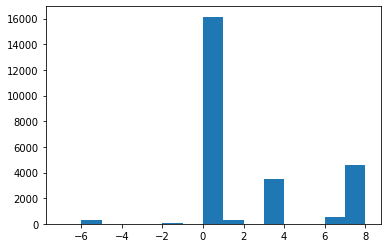

In [8]:
# calculate outcome for each drive - applied for over-time model
eScoreDiff = pbp_df.groupby(['gamecode','driveid','offenseTeam'])[['gamecode','driveid','offenseTeam','scoreDiffAfter']].tail(1).\
                reset_index(drop=True)
sScoreDiff = pbp_df.groupby(['gamecode','driveid','offenseTeam'])[['gamecode','driveid','offenseTeam','scoreDiff']].head(1).reset_index(drop=True)

eScoreDiff['driveScoreDiffChange'] = (eScoreDiff.scoreDiffAfter - sScoreDiff.scoreDiff)
eScoreDiff['driveOutcome'] = 0  # no-score
eScoreDiff.loc[eScoreDiff.driveScoreDiffChange ==1, 'driveOutcome'] = 1  # FG
eScoreDiff.loc[eScoreDiff.driveScoreDiffChange ==2, 'driveOutcome'] = 2  # FG
eScoreDiff.loc[eScoreDiff.driveScoreDiffChange ==3, 'driveOutcome'] = 3  # FG
eScoreDiff.loc[eScoreDiff.driveScoreDiffChange ==6, 'driveOutcome'] = 4  # TD w.o. extra point
eScoreDiff.loc[eScoreDiff.driveScoreDiffChange ==7, 'driveOutcome'] = 5  # TD w extra point
eScoreDiff.loc[eScoreDiff.driveScoreDiffChange ==8, 'driveOutcome'] = 6  # TD w extra point
eScoreDiff.loc[eScoreDiff.driveScoreDiffChange ==-2, 'driveOutcome'] = 7 # defense points from offense turn-over
eScoreDiff.loc[eScoreDiff.driveScoreDiffChange ==-6, 'driveOutcome'] = 8 # defense points from offense turn-over

plt.hist(eScoreDiff.driveScoreDiffChange, bins=range(-7,9))

In [9]:
# eScoreDiff.head()
driveOutcomes = eScoreDiff[['offenseTeam','driveOutcome']].copy()
driveOutcomes[['share']] = 0
driveOutcomes = driveOutcomes.groupby(['offenseTeam','driveOutcome'])[['share']].count()
driveOutcomes = driveOutcomes.groupby(['offenseTeam']).apply(lambda x: x/x.sum())
driveOutcomes.reset_index(inplace=True)

driveOutcomes[driveOutcomes.offenseTeam==329] # 348 NE, 329 Cleveland

,offenseTeam,driveOutcome,share
40,329,0,0.700258
41,329,1,0.003876
42,329,3,0.103359
43,329,4,0.028424
44,329,5,0.133075
45,329,6,0.010336
46,329,7,0.006460
47,329,8,0.014212


In [10]:
eScoreDiff.shape
driveOutcomes.shape
#pbp_df.shape

(263, 3)

In [11]:
pbp_df = pd.merge(pbp_df, eScoreDiff[['gamecode','driveid','offenseTeam','driveScoreDiffChange','driveOutcome']], on=['gamecode','driveid','offenseTeam'])
sScoreDiff.rename(columns={'scoreDiff':'driveStartScoreDiff'}, inplace=True)
pbp_df = pd.merge(pbp_df, sScoreDiff[['gamecode','driveid','offenseTeam','driveStartScoreDiff']], on=['gamecode','driveid','offenseTeam'])
pbp_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 173665 entries, 0 to 173664
Data columns (total 43 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   season                    173665 non-null  Int64  
 1   week                      173665 non-null  Int64  
 2   gamecode                  173665 non-null  Int64  
 3   eventtypeid               173665 non-null  Int64  
 4   gameUTCTime               173665 non-null  Int64  
 5   homeTeam                  173665 non-null  Int64  
 6   awayTeam                  173665 non-null  Int64  
 7   offenseTeam               173665 non-null  Int64  
 8   defenseTeam               173665 non-null  Int64  
 9   playid                    173665 non-null  Int64  
 10  driveid                   173665 non-null  Int64  
 11  period                    173665 non-null  Int64  
 12  secondsRemainingInPeriod  173665 non-null  float64
 13  gameTime                  173665 non-null  f

## 0.2 Game data

In [30]:
id = (win_df.homeTeam==win_df.offenseTeam) & (win_df.homeFinalScore>win_df.awayFinalScore)
id = id | ((win_df.awayTeam==win_df.offenseTeam) & (win_df.homeFinalScore<win_df.awayFinalScore))

win_df['offenseWin'] = id.astype('bool')

# regular game time outcome: 0: lose, 1: win, 2: tie
win_df['regularTimeResultForOffense'] = 0
win_df.loc[win_df.offenseWin,'regularTimeResultForOffense'] = 1
win_df.loc[win_df.overTime, 'regularTimeResultForOffense'] = 2

In [12]:
# query team game-level stats

simple_query = f'''
select 
   teamid,
   eventmetadata.gameCode as gamecode,
   gametimeinseconds,
   timeofpossessioninseconds,
   totalpoints,
   case 
       when gametimeinminutes > 60 then True
       else False
       end
       overTime
       
from datalakefootball.team_aggregated_game_stats
where 
    season>='2016' and
    eventmetadata.week is not null
    and eventmetadata.eventtypeid in (1,2)
'''

if True:
    game_df = cursor.execute(simple_query).as_pandas()
    print(game_df.info())
else:
    print("Failed to query!")
        
np.sum(game_df.overTime)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2552 entries, 0 to 2551
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   teamid                     2552 non-null   Int64  
 1   gamecode                   2552 non-null   Int64  
 2   gametimeinseconds          2552 non-null   float64
 3   timeofpossessioninseconds  2552 non-null   float64
 4   totalpoints                2552 non-null   Int64  
 5   overTime                   2552 non-null   bool   
dtypes: Int64(3), bool(1), float64(2)
memory usage: 109.8 KB
None


130

In [13]:
# fix a DB error: 2016 Denver vs Saints
id = (game_df.gamecode == 1635660) & (game_df.teamid==332)
game_df.loc[id, 'totalpoints'] = 25
game_df[id]

,teamid,gamecode,gametimeinseconds,timeofpossessioninseconds,totalpoints,overTime
311,332,1635660,3600.0,2362.0,25,False


In [14]:
# merge info for offense team
win_df = pd.merge(pbp_df, game_df, left_on=['gamecode','homeTeam'], right_on=['gamecode','teamid'])

win_df.rename(columns={'timeofpossessioninseconds':'home_TOP', 'totalpoints':'home_points'}, inplace=True)

win_df.drop(columns=['teamid','gametimeinseconds'], inplace=True)

# merge info for defense team
win_df = pd.merge(win_df, game_df.drop(['overTime'],axis=1), left_on=['gamecode','awayTeam'], right_on=['gamecode','teamid'])

win_df.rename(columns={'timeofpossessioninseconds':'away_TOP', 'totalpoints':'away_points'}, inplace=True)

win_df.drop(columns=['teamid'], inplace=True)

win_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 173665 entries, 0 to 173664
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   season                    173665 non-null  Int64  
 1   week                      173665 non-null  Int64  
 2   gamecode                  173665 non-null  Int64  
 3   eventtypeid               173665 non-null  Int64  
 4   gameUTCTime               173665 non-null  Int64  
 5   homeTeam                  173665 non-null  Int64  
 6   awayTeam                  173665 non-null  Int64  
 7   offenseTeam               173665 non-null  Int64  
 8   defenseTeam               173665 non-null  Int64  
 9   playid                    173665 non-null  Int64  
 10  driveid                   173665 non-null  Int64  
 11  period                    173665 non-null  Int64  
 12  secondsRemainingInPeriod  173665 non-null  float64
 13  gameTime                  173665 non-null  f

In [15]:
id = (win_df.homeTeam==win_df.offenseTeam) & (win_df.home_points>win_df.away_points)
id = id | ((win_df.awayTeam==win_df.offenseTeam) & (win_df.home_points<win_df.away_points))

win_df['offenseWin'] = id.astype('bool')

In [16]:
# NCAA not allowing for tie
id = (win_df.homeTeam==win_df.offenseTeam) & (win_df.homeFinalScore>win_df.awayFinalScore)
id = id | ((win_df.awayTeam==win_df.offenseTeam) & (win_df.homeFinalScore<win_df.awayFinalScore))

win_df['offenseWin_2'] = id.astype('bool')

In [18]:
np.where(win_df.offenseWin != win_df.offenseWin_2)

(array([29328, 29329, 29330, 29331, 29332, 29333, 29334, 29335, 29336,
        29337, 29338, 29339, 29340, 29341, 29342, 29343, 29344, 29345,
        29346, 29347, 29348, 29349, 29350, 29351, 29352, 29353, 29354,
        29355, 29356, 29357, 29358, 29359, 29360, 29361, 29362, 29363,
        29364, 29365, 29366, 29367, 29368, 29369, 29370, 29371, 29372,
        29373, 29374, 29375, 29376, 29377, 29378, 29379, 29380, 29381,
        29382, 29383, 29384, 29385, 29386, 29387, 29388, 29389, 29390,
        29391, 29392, 29393, 29394, 29395, 29396, 29397, 29398, 29399,
        29400, 29401, 29402, 29403, 29404, 29405, 29406, 29407, 29408,
        29409, 29410, 29411, 29412, 29413, 29414, 29415, 29416, 29417,
        29418, 29419, 29420, 29421, 29422, 29423, 29424, 29425, 29426,
        29427, 29428, 29429, 29430, 29431, 29432, 29433, 29434, 29435,
        29436, 29437, 29438, 29439, 29440, 29441, 29442, 29443, 29444,
        29445, 29446, 29447, 29448, 29449, 29450, 29451, 29452, 29453,
      

In [28]:
win_df[29327:29337]
win_df['regularTimeResultForOffense'] = 0
win_df.loc[win_df.offenseWin_2,'regularTimeResultForOffense'] = 1
win_df.loc[win_df.overTime, 'regularTimeResultForOffense'] = 2

In [29]:
print(sum(win_df.regularTimeResultForOffense==0))
print(sum(win_df.regularTimeResultForOffense==1))
print(sum(win_df.regularTimeResultForOffense==2))

79201
84137
10327


In [25]:
# regular game time outcome: 0: lose, 1: win, 2: tie
win_df['regularTimeResultForOffense'] = 0

id = (win_df.homeTeam==win_df.offenseTeam) & (win_df.home_points>win_df.away_points)
id = id | ((win_df.awayTeam==win_df.offenseTeam) & (win_df.home_points<win_df.away_points))

win_df.regularTimeResultForOffense[id] = 1

id = win_df.overTime
win_df.regularTimeResultForOffense[id] = 2

In [31]:
print(sum(win_df.regularTimeResultForOffense==0))
print(sum(win_df.regularTimeResultForOffense==1))
print(sum(win_df.regularTimeResultForOffense==2))

79201
84137
10327


In [ ]:
sum(win_df.regularTimeResultForOffense==2)

## 0.3 Pre-game odds

In [32]:
simple_query = f'''
WITH subQuery AS
(
    SELECT
        event.eventId AS eventId,
        lineList.scope.name AS lineScope,
        lineList.line AS lineData,
        cast(season as integer) season,
        eventmetadata.gamecode gamecode
    FROM datalakefootball.odds,
        UNNEST(event.lines) t(lineList)
    WHERE leagueid='8'
)
SELECT
    --season,
    gamecode,
    --eventId,
    lineScope,
    sublineList.lineType.name AS lineType,
    --sublineList.total AS overUnderPoints,
    sublineList.favoritePoints,
    sublineList.favoriteTeamId
    --sublineList
FROM subQuery,
    UNNEST(lineData) t(sublineList)
WHERE sublineList.lineType.name = 'current' and season >= 2016 and season <= 2019
'''

if True:
    odds_df = cursor.execute(simple_query).as_pandas()
    print(odds_df.info())
else:
    print("Failed to query!")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1331 entries, 0 to 1330
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gamecode        1331 non-null   Int64  
 1   lineScope       1331 non-null   object 
 2   lineType        1331 non-null   object 
 3   favoritepoints  1331 non-null   float64
 4   favoriteteamid  1331 non-null   Int64  
dtypes: Int64(2), float64(1), object(2)
memory usage: 54.7+ KB
None


In [33]:
win_df = pd.merge(win_df, odds_df, left_on=['gamecode'], right_on=['gamecode'])

win_df['offenseFavoritePoints'] = win_df.favoritepoints
id = win_df.defenseTeam == win_df.favoriteteamid
win_df.loc[id, 'offenseFavoritePoints'] = win_df.favoritepoints[id] * (-1)

## 0.4 legacy in-game win probability

In [ ]:
def parseInGameWinProb(url):

    legacy_win = requests.get(legacy_win_url).json()

    gameList = []

    for j_obj in legacy_win['apiResults'][0]['league']['season']['eventType'][0]['winProbability']:
        eventId = j_obj['eventId']
        print(eventId)

        oneGame = pd.json_normalize(j_obj['pbp'], ['teams'], ['playId'], record_prefix='', errors='ignore')
        oneGame['gamecode'] = eventId

        gameList.append(oneGame)
        
    print(len(gameList))

    df = pd.concat(gameList)
    
    return df

In [ ]:
# 2019 week 1, 20190908
legacy_win_url = 'http://api.stats.com/v1/stats/football/nfl/winProbability/?date=2019-09-08&accept=json&api_key=nv8332hg23gc6sqtxmwkk7c7&sig=2c6cb7e118f75f22b56d6494bba13974d78b126a7531c622a3ffcf9fe854cf65'
legacy_win_1 = parseInGameWinProb(legacy_win_url)

In [ ]:
# 2019 week 5, 20191006
legacy_win_url = 'http://api.stats.com/v1/stats/football/nfl/winProbability/?date=2019-10-06&accept=json&api_key=nv8332hg23gc6sqtxmwkk7c7&sig=0de6c1ef4bba89822a64e68b86ef4b79a1ec02d6684f690f627ffefc912d18e8'
legacy_win_5 = parseInGameWinProb(legacy_win_url)

In [ ]:
# 2019 week 9, 20191103
legacy_win_url = 'http://api.stats.com/v1/stats/football/nfl/winProbability/?date=2019-11-03&accept=json&api_key=nv8332hg23gc6sqtxmwkk7c7&sig=eb2892743069d4f78ce5fe4412d77c6cc2bd740e00b7c46fb88ed1eaeb709647'
legacy_win_9 = parseInGameWinProb(legacy_win_url)

In [ ]:
# 2019 week 10, 20191111
legacy_win_url = 'http://api.stats.com/v1/stats/football/nfl/winProbability/?date=2019-11-11&accept=json&api_key=nv8332hg23gc6sqtxmwkk7c7&sig=4710d87e5f884d99d5b27bcb7500167f9f28f9b4e7d60b2aafde272d04d25f1a'
legacy_win_10 = parseInGameWinProb(legacy_win_url)

In [ ]:
# 2019 week 14, 20191209
legacy_win_url = 'http://api.stats.com/v1/stats/football/nfl/winProbability/?date=2019-12-09&accept=json&api_key=nv8332hg23gc6sqtxmwkk7c7&sig=d1f710b76f8340919da81cde7947b21c110bf545d905fd174e13793dcdf7b027'
legacy_win_14 = parseInGameWinProb(legacy_win_url)

In [ ]:
# 2019 week 16, 20191222
legacy_win_url = 'http://api.stats.com/v1/stats/football/nfl/winProbability/?date=2019-11-03&accept=json&api_key=nv8332hg23gc6sqtxmwkk7c7&sig=eb2892743069d4f78ce5fe4412d77c6cc2bd740e00b7c46fb88ed1eaeb709647'
legacy_win_16 = parseInGameWinProb(legacy_win_url)

In [ ]:
# 2019 week 18, gamecode: 2142279
legacy_win_url = 'http://api.stats.com/v1/stats/football/nfl/winProbability/2142279?accept=json&api_key=nv8332hg23gc6sqtxmwkk7c7&sig=872cd6167a0accece08b4951f65fbb3c0d424fadc55aff33053f75ea46ac5c20'
legacy_win_18_1 = parseInGameWinProb(legacy_win_url)

In [ ]:
# 2019 week 18, gamecode: 2142276
legacy_win_url = 'http://api.stats.com/v1/stats/football/nfl/winProbability/2142276?accept=json&api_key=nv8332hg23gc6sqtxmwkk7c7&sig=3beff69bcc717c094c45246d55788caf08f29ca1fdb73b82fa3796ceb817a5f7'
legacy_win_18_2 = parseInGameWinProb(legacy_win_url)

In [ ]:
# 2019 week 22, superball, gamecode: 
legacy_win_url = 'http://api.stats.com/v1/stats/football/nfl/winProbability/2142306?accept=json&api_key=nv8332hg23gc6sqtxmwkk7c7&sig=8b7e53342dabecf2d4cbda6cba59989f7c6d585911a8149b1e8ccd5a9088d3aa'
legacy_win_22 = parseInGameWinProb(legacy_win_url)

In [ ]:
legacy_win = pd.concat([legacy_win_1, legacy_win_5, legacy_win_9, legacy_win_10, legacy_win_14, \
                        legacy_win_16, legacy_win_18_1, legacy_win_18_2, legacy_win_22], axis=0)
legacy_win.shape

In [ ]:
legacy_win['winProbability.before'] = legacy_win['winProbability.before'].astype('float64')
legacy_win['winProbability.after'] = legacy_win['winProbability.after'].astype('float64')
legacy_win['playId'] = legacy_win['playId'].astype('int64')
legacy_win.info()

In [ ]:
win_df.drop(['teamId','winProbability.before','winProbability.after','playId'], axis=1, inplace=True)
#win_df[win_df.season==2019].gamecode.unique()

In [ ]:
win_df=pd.merge(win_df, legacy_win, left_on=['gamecode', 'offenseTeam','playid'], right_on=['gamecode','teamId','playId'], how='left')
win_df.info()

In [ ]:
legacy_win.gamecode.unique().shape

# 1 Feature/label creation

## 1.1 features during regular time

### (1) features for drive outcome

In [34]:
reg_df = win_df[win_df.period<=4]

id_train = (reg_df.season < 2019)  #| (win_df.week < 22)) & (win_df.period<=4)
id_test  = (reg_df.season == 2019) # & (~win_df['winProbability.before'].isnull())
id_superball = (reg_df.season == 2019) & (reg_df.week==22) # & (~win_df['winProbability.before'].isnull()) & (win_df.week==22)

num_fields = [
                'scoreDiff',
                'adjScoreDiff',
                #'expectedExtraScore',
                #'expectedScoreDiff',
                #'expectedAdjScoreDiff',
                #'expectedDriveScoreDiff',
                #'driveStartScoreDiff',
                #'expectedDriveScore',
                #'expectedAdjDriveScoreDiff', 
                'secondsRemainingInPeriod',
                'remainingGameTime',
                'yardsToGo',
                'yardsFromGoal',
                'offenseFavoritePoints',
                'offenseScore',
                'remainingOffenseTOs',
                'remainingDefenseTOs',
             ]

cat_fields = [
                'eventtypeid',
                 'period',
                 'down',
                 'playDesign'
                #'offenseTimeout',
                #'defenseTimeout'
             ] 

# None-StandardScaler version
transform_pipeline_drive = ColumnTransformer(transformers=[
                                            ('num', 'passthrough', num_fields),
                                            ('cat', OneHotEncoder(categories='auto'), cat_fields)
                                        ])

features_train_drive = transform_pipeline_drive.fit_transform(reg_df[id_train])
features_test_drive = transform_pipeline_drive.transform(reg_df[id_test])

feature_names = num_fields.copy()
cat_one_hot_fields = list(transform_pipeline_drive.named_transformers_.cat.get_feature_names(input_features=cat_fields))
feature_names.extend(cat_one_hot_fields)
cat_one_hot_fields

if type(features_train_drive) == np.ndarray:
    features_train_drive = pd.DataFrame(features_train_drive, columns=feature_names, dtype=np.float)
    features_test_drive  = pd.DataFrame(features_test_drive, columns=feature_names, dtype=np.float)
else:
    features_train_drive = pd.DataFrame(features_train_drive.toarray(), columns=feature_names, dtype=np.float)
    features_test_drive  = pd.DataFrame(features_test_drive.toarray(), columns=feature_names, dtype=np.float)

print(features_train_drive.shape, features_test_drive.shape)

(129351, 25) (43165, 25)


In [35]:
# classification label for the whole game
label_train_drive = reg_df.driveOutcome[id_train]
label_test_drive  = reg_df.driveOutcome[id_test]

In [36]:
model_RFC_drive = RandomForestClassifier(n_estimators=500, max_depth=25, min_samples_leaf=20, random_state=42)
model_RFC_drive.fit(features_train_drive, label_train_drive) # features is from section 1.0
#pred_d = model_RFC_drive.predict_proba(features)

RandomForestClassifier(max_depth=25, min_samples_leaf=20, n_estimators=500,
                       random_state=42)

### (2) features for game outcome

In [37]:
# use drive outcome model to create a feature 
# calculate expected score

features_drive = transform_pipeline_drive.transform(reg_df)

pred_d = model_RFC_drive.predict_proba(features_drive)

reg_df['expectedDriveScore'] = np.dot(pred_d, np.array([0,1,2,3,6,7,8,-2,-6]))
reg_df['expectedScoreDiff'] = reg_df.driveStartScoreDiff + reg_df.expectedDriveScore
reg_df['adjExpectedScoreDiff'] = reg_df.expectedScoreDiff / np.power(reg_df.remainingGameTime+1, 0.5)

reg_df['expectedExtraScore'] = reg_df.driveStartScoreDiff - reg_df.scoreDiff + reg_df.expectedDriveScore

In [38]:
num_fields = [
                'scoreDiff',
                'expectedExtraScore',
                #'adjScoreDiff',
                #'expectedScoreDiff',
                #'expectedAdjScoreDiff',
                #'expectedDriveScoreDiff',
                #'driveStartScoreDiff',
                #'expectedDriveScore',
                'adjExpectedScoreDiff', 
                'secondsRemainingInPeriod',
                'remainingGameTime',
                'yardsToGo',
                'yardsFromGoal',
                'offenseFavoritePoints',
                'offenseScore',
                'remainingOffenseTOs',
                'remainingDefenseTOs',
             ]

cat_fields = [
                'eventtypeid',
                 'period',
                 'down',
                 'playDesign'
                #'offenseTimeout',
                #'defenseTimeout'
             ] 

# None-StandardScaler version
transform_pipeline_2 = ColumnTransformer(transformers=[
                                            ('num', 'passthrough', num_fields),
                                            ('cat', OneHotEncoder(categories='auto'), cat_fields)
                                        ])
features_train = transform_pipeline_2.fit_transform(reg_df[id_train])
features_test  = transform_pipeline_2.transform(reg_df[id_test])
features_superball = transform_pipeline_2.transform(reg_df[id_superball])
#print(features.shape)

feature_names = num_fields.copy()
cat_one_hot_fields = list(transform_pipeline_2.named_transformers_.cat.get_feature_names(input_features=cat_fields))
feature_names.extend(cat_one_hot_fields)
cat_one_hot_fields

if type(features_train) == np.ndarray:
    features_train = pd.DataFrame(features_train, columns=feature_names, dtype=np.float)
    features_test  = pd.DataFrame(features_test,  columns=feature_names, dtype=np.float)
    features_superball  = pd.DataFrame(features_superball,  columns=feature_names, dtype=np.float)
else:
    features_train = pd.DataFrame(features_train.toarray(), columns=feature_names, dtype=np.float)
    features_test  = pd.DataFrame(features_test.toarray(),  columns=feature_names, dtype=np.float)
    features_superball  = pd.DataFrame(features_superball.toarray(),  columns=feature_names, dtype=np.float)

print(features_train.shape, features_test.shape, features_superball.shape)

(129351, 26) (43165, 26) (157, 26)


In [39]:
# classification label for the whole game
label_train = reg_df.offenseWin[id_train]
label_test  = reg_df.offenseWin[id_test]
label_superball  = reg_df.offenseWin[id_superball]

In [ ]:
print(sum(id_test) )
legacy_prob=reg_df['winProbability.before'][id_test]
legacy_prob_superball=reg_df['winProbability.before'][id_superball]

In [ ]:
features_superball.info()

## 1.2 features during over-time

In [ ]:
# note: for OT, starting the 2nd round, only a field goal is enough, so the probability to do that is much higher!!!

num_fields = [
                'scoreDiff',
                #'adjScoreDiff',
                #'secondsRemainingInPeriod',
                'yardsToGo',
                'yardsFromGoal',
                'offenseFavoritePoints',
                #'remainingGameTime',
                #'offenseScore',
                'remainingOffenseTOs',
                'remainingDefenseTOs',
             ]

cat_fields = [
                'eventtypeid',
                #'period',
                'down',
                'playDesign'
                #'offenseTimeout',
                #'defenseTimeout'
             ] 

# None-StandardScaler version
transform_pipeline_2 = ColumnTransformer(transformers=[
                                            ('num', 'passthrough', num_fields),
                                            ('cat', OneHotEncoder(categories='auto'), cat_fields)
                                        ])
features = transform_pipeline_2.fit_transform(win_df)
print(features.shape)

feature_names_o = num_fields.copy()
cat_one_hot_fields = list(transform_pipeline_2.named_transformers_.cat.get_feature_names(input_features=cat_fields))
feature_names_o.extend(cat_one_hot_fields)
cat_one_hot_fields

if type(features) == np.ndarray:
    features = pd.DataFrame(features, columns=feature_names_o)
else:
    features = pd.DataFrame(features.toarray(), columns=feature_names_o)

features.info()

In [ ]:
id_train_o = (win_df.season < 2019) #| ~win_df.overTime
id_test_o  = (win_df.season == 2019) #& win_df.overTime #& (~win_df['winProbability.before'].isnull())

# classification label for the whole game
label_o_train = win_df.driveOutcome[id_train_o]
label_o_test  = win_df.driveOutcome[id_test_o]
#label_o_superball  = win_df.driveOutcome[id_superball]

features_o_train=features.loc[id_train_o]
features_o_test =features.loc[id_test_o]
#features_o_superball =features.loc[id_superball]

print(sum(id_train_o), sum(id_test_o))

In [ ]:
cat_fields = [
                'offenseTeam',
             ] 

# None-StandardScaler version
transform_pipeline_3 = ColumnTransformer(transformers=[
                                            ('cat', OneHotEncoder(categories='auto'), cat_fields)
                                        ])

features = transform_pipeline_3.fit_transform(win_df)
print(features.shape)

feature_names_d = []
cat_one_hot_fields = list(transform_pipeline_3.named_transformers_.cat.get_feature_names(input_features=cat_fields))
feature_names_d.extend(cat_one_hot_fields)
print(cat_one_hot_fields)

if type(features) == np.ndarray:
    features = pd.DataFrame(features, columns=feature_names_d)
else:
    features = pd.DataFrame(features.toarray(), columns=feature_names_d)

id_train_o = (win_df.season < 2019) #| ~win_df.overTime
id_test_o  = (win_df.season == 2019) #& win_df.overTime #& (~win_df['winProbability.before'].isnull())

features_d_train=features.loc[id_train_o]
features_d_test =features.loc[id_test_o]

# classification label for the whole game
label_d_train = (win_df.driveOutcome==0)[id_train_o]
label_d_test  = (win_df.driveOutcome==0)[id_test_o]

In [ ]:
driveOutcomes[driveOutcomes.offenseTeam.isin([357,338, 332])]

In [ ]:
print(sum(id_test_o) )
legacy_prob_o=win_df['winProbability.before'][id_test_o]

# 2 Model Study

## 2.0 play outcome model

In [ ]:
# instantiate models
folds = 5

model_RFC_play = RandomForestClassifier(n_estimators=200, max_depth=15, min_samples_leaf=20, random_state=42)

In [ ]:
# Random forest classification

scores_RFC_play = cross_validate(model_RFC_play,
    features_train_play,
    label_train_play,
    cv=folds,
    scoring=(['recall_micro','precision_micro','f1_micro','roc_auc_ovr_weighted']))
print('Win Probability - Random Forest Classifier (P/R/F1/ROC): {:.1%}  {:.1%}  {:.1%} {:.1%}'.format(scores_RFC_play['test_recall_micro'].mean(), 
                                                                                scores_RFC_play['test_precision_micro'].mean(), 
                                                                                scores_RFC_play['test_f1_micro'].mean(),
                                                                                scores_RFC_play['test_roc_auc_ovr_weighted'].mean()))
#sorted(SCORERS.keys()) 

In [ ]:
# feature importance study
model_RFC_plfeatures_trainay.fit(_play, label_train_play)
feature_score = pd.DataFrame([feature_names_play, model_RFC_play.feature_importances_], index=['feature','importance']).transpose()
feature_score.sort_values(by='importance', ascending=False)

## 2.1 Regular game time

In [40]:
# instantiate models
folds = 5

model_logistic = LogisticRegression(solver='lbfgs', fit_intercept=True, max_iter=10000, tol=1e-4, random_state=42)

model_RFC = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=10, random_state=42)

model_SGD = SGDClassifier(loss='log', penalty=None, fit_intercept=True, max_iter=10000, tol=1e-4, random_state=42)

model_SVC = LinearSVC(max_iter=10000, tol=1e-4, random_state=42)

model_RFR = RandomForestRegressor(n_estimators=100, max_depth=20, min_samples_leaf=10, random_state=42)

In [41]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

def create_DL_model():
    model_DL = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[26,]),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(250, activation='elu', kernel_initializer="he_normal"),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(150, activation='elu', kernel_initializer="he_normal"),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(80, activation='elu', kernel_initializer="he_normal"),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(30, activation='elu', kernel_initializer="he_normal"),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(1, activation='sigmoid')
    ])

    # multi-nomial classification
    #model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['AUC'])

    # binary classification
    optimizer = keras.optimizers.SGD(learning_rate=0.01, decay=1e-4)
    model_DL.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[['accuracy', 'AUC']])

    #model_DL.summary()
    
    return model_DL

model_DL = KerasClassifier(build_fn=create_DL_model, epochs=70, verbose=1)

In [42]:
def create_DL_2_model():
    input_ = keras.layers.Input(shape=features_train_drive.shape[1:], name='input')
    input_a = keras.layers.Input(shape=features_train_drive.shape[1:], name='input_a')

    hidden_1 = keras.layers.BatchNormalization()(input_)

    hidden_a1 = keras.layers.BatchNormalization()(input_a)
    hidden_a2 = keras.layers.Dense(100, activation='elu', kernel_initializer="he_normal")(hidden_a1)
    hidden_a3 = keras.layers.BatchNormalization()(hidden_a2)
    hidden_a4 = keras.layers.Dense(20, activation='elu', kernel_initializer="he_normal")(hidden_a3)
    hidden_a5 = keras.layers.BatchNormalization()(hidden_a4)

    aux_output = keras.layers.Dense(9, name='aux_output', activation='softmax')(hidden_a5)

    concat = keras.layers.concatenate([hidden_1, aux_output])


    hidden_2 = keras.layers.Dense(250, activation='elu', kernel_initializer="he_normal")(concat)
    hidden_3 = keras.layers.BatchNormalization()(hidden_2)

    hidden_4 = keras.layers.Dense(150, activation='elu', kernel_initializer="he_normal")(hidden_3)
    hidden_5 = keras.layers.BatchNormalization()(hidden_4)

    hidden_6 = keras.layers.Dense(80, activation='elu', kernel_initializer="he_normal")(hidden_5)
    hidden_7 = keras.layers.BatchNormalization()(hidden_6)

    hidden_8 = keras.layers.Dense(80, activation='elu', kernel_initializer="he_normal")(hidden_7)
    hidden_9 = keras.layers.BatchNormalization()(hidden_8)

    #concat = keras.layers.concatenate([hidden_7, aux_output])

    output = keras.layers.Dense(1, name='main_output', activation='sigmoid')(hidden_9)

    model_DL_2 = keras.Model(inputs=[input_, input_a], outputs=[output, aux_output])

    optimizer = keras.optimizers.SGD(learning_rate=0.01, decay=1e-4)
    model_DL_2.compile(loss=['binary_crossentropy','sparse_categorical_crossentropy'], loss_weights=[0.90, 0.10], 
                    optimizer=optimizer, metrics=[['accuracy'],['accuracy']])

    return model_DL_2

model_DL_2 = KerasClassifier(build_fn=create_DL_2_model, epochs=70, verbose=1)

In [ ]:
# Logistic regression model

scores_logistic = cross_validate(model_logistic,
    features_train,
    label_train,
    cv=folds,
    scoring=(['recall','precision','f1','roc_auc']))
print('Pass - Linear logistic regression (P/R/F1/ROC): {:.1%}  {:.1%}  {:.1%} {:.1%}'.format(scores_logistic['test_recall'].mean(), 
                                                                                   scores_logistic['test_precision'].mean(), 
                                                                                   scores_logistic['test_f1'].mean(),
                                                                                  scores_logistic['test_roc_auc'].mean()))

In [43]:
# Random forest classification

scores_RFC = cross_validate(model_RFC,
    features_train,
    label_train,
    cv=folds,
    scoring=(['recall','precision','f1','roc_auc']))
print('Win Probability - Random Forest Classifier (P/R/F1/ROC): {:.2%}  {:.2%}  {:.2%} {:.2%}'.format(scores_RFC['test_recall'].mean(), 
                                                                                scores_RFC['test_precision'].mean(), 
                                                                                scores_RFC['test_f1'].mean(),
                                                                                scores_RFC['test_roc_auc'].mean()))

Win Probability - Random Forest Classifier (P/R/F1/ROC): 80.17%  79.48%  79.82% 87.77%


In [ ]:
# Deep learning classification

scores_DL = cross_validate(model_DL,
    features_train,
    label_train,
    cv=folds,
    scoring=(['recall','precision','f1','roc_auc']))
print('Win Probability - Random Forest Classifier (P/R/F1/ROC): {:.2%}  {:.2%}  {:.2%} {:.2%}'.format(scores_DL['test_recall'].mean(), 
                                                                                scores_DL['test_precision'].mean(), 
                                                                                scores_DL['test_f1'].mean(),
                                                                                scores_DL['test_roc_auc'].mean()))

In [ ]:
# Deep learning classification

scores_DL2 = cross_validate(model_DL,
    features_train,
    label_train,
    cv=folds,
    scoring=(['recall','precision','f1','roc_auc']))
print('Win Probability - Random Forest Classifier (P/R/F1/ROC): {:.2%}  {:.2%}  {:.2%} {:.2%}'.format(scores_DL2['test_recall'].mean(), 
                                                                                scores_DL2['test_precision'].mean(), 
                                                                                scores_DL2['test_f1'].mean(),
                                                                                scores_DL2['test_roc_auc'].mean()))

In [ ]:
# Random forest regression

scores_RFR = cross_validate(model_RFR,
    features_train,
    label_train,
    cv=folds,
    scoring=(['neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2']))
print(f"Win Probability - Random Forest Regression (mae/rmse/r2): \
      {-scores_RFR['test_neg_mean_absolute_error'].mean():.3} \
      {-scores_RFR['test_neg_root_mean_squared_error'].mean():.3} \
      {scores_RFR['test_r2'].mean():.3}")

In [ ]:
# feature importance study
model_RFC.fit(features_train, label_train)
feature_score = pd.DataFrame([feature_names, model_RFC.feature_importances_], index=['feature','importance']).transpose()
feature_score.sort_values(by='importance', ascending=False)

## 2.2 Overtime

In [ ]:
# instantiate models
folds = 5

model_logistic = LogisticRegression(solver='lbfgs', fit_intercept=True, max_iter=10000, tol=1e-4, random_state=42)

model_RFC_o = RandomForestClassifier(n_estimators=200, max_depth=15, min_samples_leaf=10, random_state=42)

model_RFC_d = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=10, random_state=42)


In [ ]:
from sklearn.multiclass import OneVsRestClassifier


model_multi_class = OneVsRestClassifier(LogisticRegression(solver='lbfgs', fit_intercept=True, max_iter=10000, tol=1e-4, random_state=42))

In [ ]:
# Logistic regression model

scores_logistic_o = cross_validate(model_multi_class,
    features_o_train,
    label_o_train,
    cv=folds,
    scoring=(['recall_micro','precision_micro','f1_micro','roc_auc_ovr_weighted']))
print('Drive outcome - logistic regression Classifier (P/R/F1/ROC): {:.1%}  {:.1%}  {:.1%} {:.1%}'.format(scores_logistic_o['test_recall_micro'].mean(), 
                                                                                scores_logistic_o['test_precision_micro'].mean(), 
                                                                                scores_logistic_o['test_f1_micro'].mean(),
                                                                                scores_logistic_o['test_roc_auc_ovr_weighted'].mean()))

In [ ]:
# Random forest classification

scores_RFC_o = cross_validate(model_RFC,
    features_o_train,
    label_o_train,
    cv=folds,
    scoring=(['recall_micro','precision_micro','f1_micro','roc_auc_ovr_weighted']))
print('Drive outcome - Random Forest Classifier (P/R/F1/ROC): {:.1%}  {:.1%}  {:.1%} {:.1%}'.format(scores_RFC_o['test_recall_micro'].mean(), 
                                                                                scores_RFC_o['test_precision_micro'].mean(), 
                                                                                scores_RFC_o['test_f1_micro'].mean(),
                                                                                scores_RFC_o['test_roc_auc_ovr_weighted'].mean()))
#sorted(SCORERS.keys()) 

In [3]:
tf.__version__

'2.3.1'

In [ ]:
# feature importance study
model_RFC_o.fit(features_o_train, label_o_train)
feature_score = pd.DataFrame([feature_names_o, model_RFC_o.feature_importances_], index=['feature','importance']).transpose()
feature_score.sort_values(by='importance', ascending=False)

In [ ]:
tmp=features_o_test[:1]
tmp

In [ ]:
pred_train = model_RFC_o.predict_proba(features_o_train) #features_o_test[:1])
roc_auc_score(label_o_train, pred_train, multi_class='ovr')

In [ ]:
pred_test = model_RFC_o.predict_proba(features_o_test) #features_o_test[:1])
roc_auc_score(label_o_test, pred_test, multi_class='ovr')

In [ ]:
model_logistic.fit(features_d_train, label_d_train)

from sklearn.linear_model import LinearRegression
model_linear = LinearRegression(fit_intercept=False)
model_linear.fit(features_d_train, label_d_train)

In [ ]:
model_logistic.predict_proba(features_d_train[:3])

In [ ]:
model_linear.predict(features_d_train[:3])

In [ ]:
driveOutcomes[driveOutcomes.offenseTeam==332]

In [ ]:
features_d_train[:3]

# 3 Model prediction

## 3.1 regular time model

### 3.1.1 ML model

In [ ]:
model_RFC.fit(features_train, label_train)
#model_logistic.fit(features_train, label_train)

In [ ]:
pred_p = model_RFC.predict_proba(features_train)
pred = model_RFC.predict(features_train)
print(roc_auc_score(label_train, pred_p[:,1]) )

pred_p = model_RFC.predict_proba(features_test)
pred = model_RFC.predict(features_test)
print(roc_auc_score(label_test, pred_p[:,1]) )

In [ ]:
roc_auc_score(label_test, pred_p[:,1])

In [ ]:
print(f'mse: {mean_squared_error(label_test, pred_p[:,1]):.3} {mean_squared_error(label_test, legacy_prob):.3}')
print(f'mae: {mean_absolute_error(label_test, pred_p[:,1]):.3} {mean_absolute_error(label_test, legacy_prob):.3}')
print(f"roc_auc: {roc_auc_score(label_test, pred_p[:,1], multi_class='ovr'):.3} \
      {roc_auc_score(label_test, legacy_prob, multi_class='ovr'):.3}")
print(f"accuracy: {accuracy_score(label_test, pred):.3} {accuracy_score(label_test, legacy_prob>0.5):.3}")
print(f"precision: {precision_score(label_test, pred):.3} {precision_score(label_test, legacy_prob>0.5):.3}")
print(f"recall: {recall_score(label_test, pred):.3} {recall_score(label_test, legacy_prob>0.5):.3}")
print(f"f1: {f1_score(label_test, pred):.3} {f1_score(label_test, legacy_prob>0.5):.3}")

In [ ]:
# plot the win-prob graph for superball 2019

pred_superball = model_RFC.predict_proba(features_superball)

gameData = win_df[id_superball].copy()
gameTime = (gameData.period - 1) * 900 + (900 - gameData.secondsRemainingInPeriod)
winProb = pred_superball[:,1]
#legacy_winProb = legacy_prob_superball.values

id = (gameData.homeTeam != gameData.offenseTeam).tolist()
winProb[id] = (1 - winProb)[id]
#legacy_winProb[id] = (1-legacy_winProb)[id]

#lossProb = 1 - winProb - tieProb

In [ ]:
# simply by "play design" feature itself is not good enough

plt.figure(figsize=[12,9])
plt.title("Super Bowl LIV In-game Win Probability for Kansas Chief")
plt.xlabel('Game Time (seconds)')
plt.ylabel('Win Probability')
plt.plot(gameTime, winProb, label='baseline')
#plt.plot(gameTime, legacy_winProb, label='legacy')
plt.plot(gameTime, [0.5]*len(gameTime), linestyle='--')
plt.legend()

plt.plot([0,3600],[0.5,0.5], linestyle='dashed')
plt.show()

In [ ]:
tmp=win_df[id_superball]
tmp['p']=winProb
tmp[41:55]

In [ ]:
pred_d[np.where(id_superball)][41:55]

In [ ]:
plt.figure(figsize=[12,9])
plt.title("Super Bowl LIV In-game Win Probability for Kansas Chief")
plt.xlabel('Game Time (seconds)')
plt.ylabel('Win Probability')
plt.plot(gameTime, winProb, label='baseline')
#plt.plot(gameTime, legacy_winProb, label='legacy')
plt.plot(gameTime, [0.5]*len(gameTime), linestyle='--')
plt.legend()

plt.plot([0,3600],[0.5,0.5], linestyle='dashed')
plt.show()

In [ ]:
plt.figure(figsize=[12,9])
plt.title("Super Bowl LIV In-game Win Probability for Kansas Chief")
plt.xlabel('Game Time (seconds)')
plt.ylabel('Win Probability')
plt.plot(gameTime, winProb, label='baseline')
plt.plot(gameTime, legacy_winProb, label='legacy')
plt.plot(gameTime, [0.5]*len(gameTime), linestyle='--')
plt.legend()

plt.plot([0,3600],[0.5,0.5], linestyle='dashed')
plt.show()

In [ ]:
# the baseline model is slow to detect the high probability of touchdown
# for this play, can we add an expected score diff for this drive as a new feature?
# this value can be based on prob distribution: TD, feild goal, no score, saftey and interception -> TD
features_superball.iloc[28:31,:]
win_df[id_superball].iloc[25:31,:]

In [ ]:
gameData = win_df[id_test].copy()
gameTime = (gameData.period - 1) * 900 + (900 - gameData.secondsRemainingInPeriod)
winProb = pred[:,1]

id = (gameData.homeTeam != gameData.offenseTeam).tolist()
winProb[id] = (1 - winProb)[id]

plt.figure(figsize=[12,9])
plt.title("Super Bowl LIV In-game Win Probability for Kansas Chief")
plt.xlabel('Game Time (seconds)')
plt.ylabel('Win Probability')
plt.plot(gameTime, winProb)
plt.plot([0,3600],[0.5,0.5], linestyle='dashed')
plt.show()

In [ ]:
tmp=win_df[id_test]
plt.plot((tmp.homeScore - tmp.awayScore).tolist())

In [ ]:
id= (win_df.period==1) & (win_df.homeScore-win_df.awayScore==7)

id1 = id & (win_df.home_points > win_df.away_points)

print(sum(id), sum(id1), sum(id1)/sum(id))

id= (win_df.period==2) & (win_df.homeScore-win_df.awayScore==7)

id1 = id & (win_df.home_points > win_df.away_points)

print(sum(id), sum(id1), sum(id1)/sum(id))

id= (win_df.period==3) & (win_df.homeScore-win_df.awayScore==7)

id1 = id & (win_df.home_points > win_df.away_points)

print(sum(id), sum(id1), sum(id1)/sum(id))

id= (win_df.period==4) & (win_df.homeScore-win_df.awayScore==7)

id1 = id & (win_df.home_points > win_df.away_points)

print(sum(id), sum(id1), sum(id1)/sum(id))

### 3.1.2 DL model

### (1) Sequential deep NN

In [ ]:
#model_DL = KerasClassifier(build_fn=create_DL_model, epochs=70, verbose=1)
model_DL=create_DL_model()

history = model_DL.fit(features_train, label_train, epochs=70, validation_data=(features_test, label_test) )

In [ ]:
pred_p = model_DL.predict_proba(features_train)
pred   = model_DL.predict_classes(features_train)
print(roc_auc_score(label_train, pred_p) )

pred_p = model_DL.predict_proba(features_test)
pred   = model_DL.predict_classes(features_test)
print(roc_auc_score(label_test, pred_p) )

In [ ]:
print(f'mse: {mean_squared_error(label_test, pred_p):.3}')#' {mean_squared_error(label_test, legacy_prob):.3}')
print(f'mae: {mean_absolute_error(label_test, pred_p):.3}')# {mean_absolute_error(label_test, legacy_prob):.3}')
print(f"roc_auc: {roc_auc_score(label_test, pred_p):.3}") # \{roc_auc_score(label_test, legacy_prob):.3}")
print(f"accuracy: {accuracy_score(label_test, pred):.3}")# {accuracy_score(label_test, legacy_prob>0.5):.3}")
print(f"precision: {precision_score(label_test, pred):.3}")# {precision_score(label_test, legacy_prob>0.5):.3}")
print(f"recall: {recall_score(label_test, pred):.3}")# {recall_score(label_test, legacy_prob>0.5):.3}")
print(f"f1: {f1_score(label_test, pred):.3}")# {f1_score(label_test, legacy_prob>0.5):.3}")

### (2) Wide & deep NN

In [ ]:
model_DL_2 = create_DL_2_model()

history_2 = model_DL_2.fit([features_train_drive, features_train_drive], [label_train, label_train_drive], epochs=70, \
                      validation_data=([features_test_drive, features_test_drive], [label_test, label_test_drive]) )

In [ ]:
pred_p = model_DL_2.predict([features_train_drive, features_train_drive])[0]
pred   = pred_p > 0.5
print(roc_auc_score(label_train, pred_p) )

pred_p = model_DL_2.predict([features_test_drive, features_test_drive])[0]
pred   = pred_p > 0.5
print(roc_auc_score(label_test, pred_p) )

In [ ]:
print(f'mse: {mean_squared_error(label_test, pred_p):.3}')#' {mean_squared_error(label_test, legacy_prob):.3}')
print(f'mae: {mean_absolute_error(label_test, pred_p):.3}')# {mean_absolute_error(label_test, legacy_prob):.3}')
print(f"roc_auc: {roc_auc_score(label_test, pred_p):.3}") # \{roc_auc_score(label_test, legacy_prob):.3}")
print(f"accuracy: {accuracy_score(label_test, pred):.3}")# {accuracy_score(label_test, legacy_prob>0.5):.3}")
print(f"precision: {precision_score(label_test, pred):.3}")# {precision_score(label_test, legacy_prob>0.5):.3}")
print(f"recall: {recall_score(label_test, pred):.3}")# {recall_score(label_test, legacy_prob>0.5):.3}")
print(f"f1: {f1_score(label_test, pred):.3}")# {f1_score(label_test, legacy_prob>0.5):.3}")

In [ ]:
model.save("in-game-win-prob-DL-model.h5")

## 3.2 Overtime model

In [ ]:
# function to simulate outcomes of OT
#
# input: features for each play, starting offense team id, starting defense team id, driveOutcomes
# 

def OvertimeWinProbabilityCalculation(features, team_1, team_2, driveOutcomes):
       
    samples = 100
    
    winProb = []
    
    team_1_prob = driveOutcomes[driveOutcomes.offenseTeam==team_1].share
    team_2_prob = driveOutcomes[driveOutcomes.offenseTeam==team_2].share

    for index, row in features.iterrows():
        
        driveId = index
        offenseTeam = row.teamid
        row.drop('teamid', inplace=True)
        
        # drive prob prediction from current play
        x = np.array(row).reshape(1,-1)
        
        start_time = time.time()
        
        play_prob = model_RFC_o.predict_proba(x)[0, :]
        
        print(offenseTeam, play_prob)
        
        team_1_wins = 0
        team_1_score = 0
        team_2_score = 0
         
        if driveId == 0: 
            for i in range(samples):
                re = simulatedOutcome_1(team_1, team_2, team_1_score, team_2_score, team_1_prob, team_2_prob, play_prob)
                if re[0]:
                    team_1_wins = team_1_wins + 1
                    #print(team_1, team_2, team_1_score, team_2_score, re[1], re[2])  
                    
        elif driveId == 1:
            team_2_score = row.scoreDiff
            
            for i in range(samples):
                re = simulatedOutcome_2(team_1, team_2, team_1_score, team_2_score, team_1_prob, team_2_prob, play_prob)
                if re[0]:
                    team_1_wins = team_1_wins + 1
                    #print(team_1, team_2, team_1_score, team_2_score, re[1], re[2])
    
        else:
            if offenseTeam==team_1:
                defenseTeam=team_2
                team_o_prob=team_1_prob
                team_d_prob=team_2_prob
            else:
                defenseTeam=team_1
                team_o_prob=team_2_prob
                team_d_prob=team_1_prob
                    
            for i in range(samples):
                re = simulatedOutcome_3(team_1, offenseTeam, defenseTeam, 0, 0, team_o_prob, team_d_prob, play_prob)
                if re[0]:
                    team_1_wins = team_1_wins + 1
                    #print(team_1, team_2, team_1_score, team_2_score, re[1], re[2])
        
        #break
        wp = np.sum(team_1_wins) / float(samples) 
        
        print(f"--- {(time.time() - start_time)} seconds, {wp} ---") 
        
        
        winProb.append( wp )
        
    return winProb


In [ ]:
# this is for team 1
from numpy import random

def simulatedOutcome_1(team_1, team_2, team_1_score, team_2_score, team_1_prob, team_2_prob, play_prob):
    
    re = random.multinomial(n=1, pvals=play_prob)
    re = np.where(re)[0][0]
    
    if re in [4,5,6]: # touch-down
        team_1_score = team_1_score + 6
        return (True, team_1_score, team_2_score)
    
    elif re in (3,): # field goal
        team_1_score = team_1_score + 3
        return simulatedOutcome_2(team_1, team_2, team_1_score, team_2_score, team_1_prob, team_2_prob, team_2_prob)
    
    elif re in (0,): # no score
        return simulatedOutcome_2(team_1, team_2, team_1_score, team_2_score, team_1_prob, team_2_prob, team_2_prob)

    else:          # safety or defense TD
        team_2_score += 2
        return (False, team_1_score, team_2_score)
    

In [ ]:
# this is for team 2

def simulatedOutcome_2(team_1, team_2, team_1_score, team_2_score, team_1_prob, team_2_prob, play_prob):
    
    re = np.random.multinomial(n=1, pvals=play_prob)
    re = np.where(re)[0][0]
    
    if re in (4,5,6): # touch-down
        team_2_score = team_2_score + 6
        return (False, team_1_score, team_2_score)
    
    elif re in (3,): # field goal
        team_2_score = team_2_score + 3
        if team_2_score > team_1_score:
            #print('#2: team 2 field goal win the game')
            return (False, team_1_score, team_2_score)
        elif team_2_score == team_1_score: # move to restart, 3rd drive
            #print("restart after team 2 field goal")
            return simulatedOutcome_3(team_1, team_1, team_2, team_1_score, team_2_score, team_1_prob, team_2_prob, team_1_prob)
        else:
            print("Error: team_2 field goal,", team_1_score, team_2_score)
            return (False, team_1_score, team_2_score)
        
    elif re in (0,):
        if team_1_score > team_2_score:
            #print('#1: team 1 field goal win the game', team_1_score, team_2_score)
            return (True, team_1_score, team_2_score)
        elif team_1_score == team_2_score:
            #print("restart after team 2 no score")
            return simulatedOutcome_3(team_1, team_1, team_2, team_1_score, team_2_score, team_1_prob, team_2_prob, team_1_prob)
        else:
            print("Error: team_2 no score")
            return (False, team_1_score, team_2_score)
        
    else:          # safety or defense TD
        team_1_score += 2
        #print("safety, team_1 wins,", team_1_score, team_2_score)
        return (True, team_1_score, team_2_score)
    

In [ ]:
# After the 1st round of one drive each team
# team_1 means the team start offense from the beginning of OT
# team_o and team_d mean offense team and defense team for each drive after the 1st round

def simulatedOutcome_3(team_1, team_o, team_d, team_o_score, team_d_score, team_o_prob, team_d_prob, play_prob):
    
    re = random.multinomial(n=1, pvals=play_prob)
    re = np.where(re)[0][0]
    
    if re in (3, 4, 5, 6): # touch-down or field goal
        team_o_score = team_o_score + 6
        if team_o == team_1:
            return (True, team_o_score, team_d_score)
        else:
            return (False, team_d_score, team_o_score)
    elif re == 0:
        return simulatedOutcome_3(team_1, team_d, team_o, team_d_score, team_o_score, team_d_prob, team_o_prob, team_d_prob)
    else:          # safety or defense TD
        team_d_score += 2
        if team_d == team_1:
            return (True, team_d_score, team_o_score)
        else:
            return (False, team_o_score, team_d_score)

In [ ]:
model_RFC_o.fit(features_o_train, label_o_train)

pred_p_o = model_RFC_o.predict_proba(features_o_test)

pred_o = model_RFC_o.predict(features_o_test)

print(balanced_accuracy_score(label_o_test, pred_o) )
#roc_auc_score(label_o_test, pred_p_o, multi_class='ovr')

In [ ]:
# only 091/1/09-08 is a tie
# only 187/17 is a win by defense from an interception
# 1st TD win: 082/1/09-08, 139/9/11-03, 301/14/12-09, 129/16/12-22, 276/18/01-05
# multiple drives and offense still wins: 043/10/11-11, 119/16/12-22, 160/5/10-06, 279/18/01-04

id = (win_df.period>=5) & (win_df.season==2019)
print(win_df[id].gamecode.unique())
id = (win_df.period>=5) & (win_df.gamecode==2142276)
win_df[id]

In [ ]:
driveOutcomes[driveOutcomes.offenseTeam==338]
#driveOutcomes.columns

In [ ]:
np.random.seed(0)

OT_gamecode = [2142082, 2142160, 2142139, 2142043, 2142301, 2142119, 2142129, 2142276, 2142279]
#[2142091]

predictions=[]
team_1_id = []
legacy_probs = []

fig, subplots = plt.subplots(5,2)

fig.set_figheight(32)
fig.set_figwidth(16)

for i, game in enumerate(OT_gamecode[:1]):
    id = (win_df.gamecode==game) & (win_df.period>=5) #& (~win_df['winProbability.before'].isnull())
    
    print(i, game, sum(id))
    
    fs = features[id]
    fs['teamid'] = win_df[id].offenseTeam
    fs['driveid']= win_df[id].driveid - win_df[id].driveid.values[0]
    fs.set_index('driveid', inplace=True)

    # teanm_1 is the starting offense team in OT
    team_1, team_2 = win_df[id].offenseTeam.values[0], win_df[id].defenseTeam.values[0]
    
    pred = OvertimeWinProbabilityCalculation(fs, team_1, team_2, driveOutcomes)
    
    predictions.extend(pred)
    
    isStartingTeam = win_df[id].offenseTeam == win_df[id].offenseTeam.values[0]
    team_1_id.extend(isStartingTeam)
    
#     legacy_p = win_df['winProbability.before'][id]
#     legacy_p[~isStartingTeam] = 1.0 - legacy_p[~isStartingTeam].copy()
    
#     legacy_probs.extend(legacy_p)
    
    plot = subplots[np.divmod(i, 2)]
    plot.set_ylim([0.0, 1.0])
    plot.set_title(game)
    plot.plot(pred, marker='o', label='simulation')
    plot.plot([0.5 for _ in pred], linestyle='--')
    #plot.plot(legacy_p.values, marker='x', label='legacy')
    plot.legend()
    
#     print(i, game, sum(id), mean_squared_error([win_df.offenseWin[id].values[0]]*sum(id), pred),\
#          mean_squared_error([win_df.offenseWin[id].values[0]]*sum(id), legacy_p))
    
    #break
    

In [ ]:
len(predictions)
id = (win_df.gamecode.isin(OT_gamecode)) & (win_df.period>=5) & (~win_df['winProbability.before'].isnull())

offensePredictions = pd.Series(predictions)
offensePredictions[~np.array(team_1_id)] = 1-offensePredictions[~np.array(team_1_id)]

In [ ]:
#id = (win_df.period>=5) & (~win_df['winProbability.before'].isnull())

legacy_p_o = win_df['winProbability.before'][id]
print(f'mse: {mean_squared_error(win_df.offenseWin[id], offensePredictions):.3} {mean_squared_error(win_df.offenseWin[id], legacy_p_o):.3}')
print(f'mae: {mean_absolute_error(win_df.offenseWin[id], offensePredictions):.3} {mean_absolute_error(win_df.offenseWin[id], legacy_p_o):.3}')

In [ ]:
print(f'mse: {mean_squared_error(win_df.offenseWin[id], offensePredictions):.3} {mean_squared_error(win_df.offenseWin[id], legacy_p_o):.3}')
print(f"roc_auc: {roc_auc_score(win_df.offenseWin[id], offensePredictions):.3} {roc_auc_score(win_df.offenseWin[id], legacy_p_o):.3}")